In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### DATA PREPROCESSING

In [3]:
df = pd.read_csv("../input/training/Training.csv")
print(df.shape)
df.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


#### Plotting the different time series

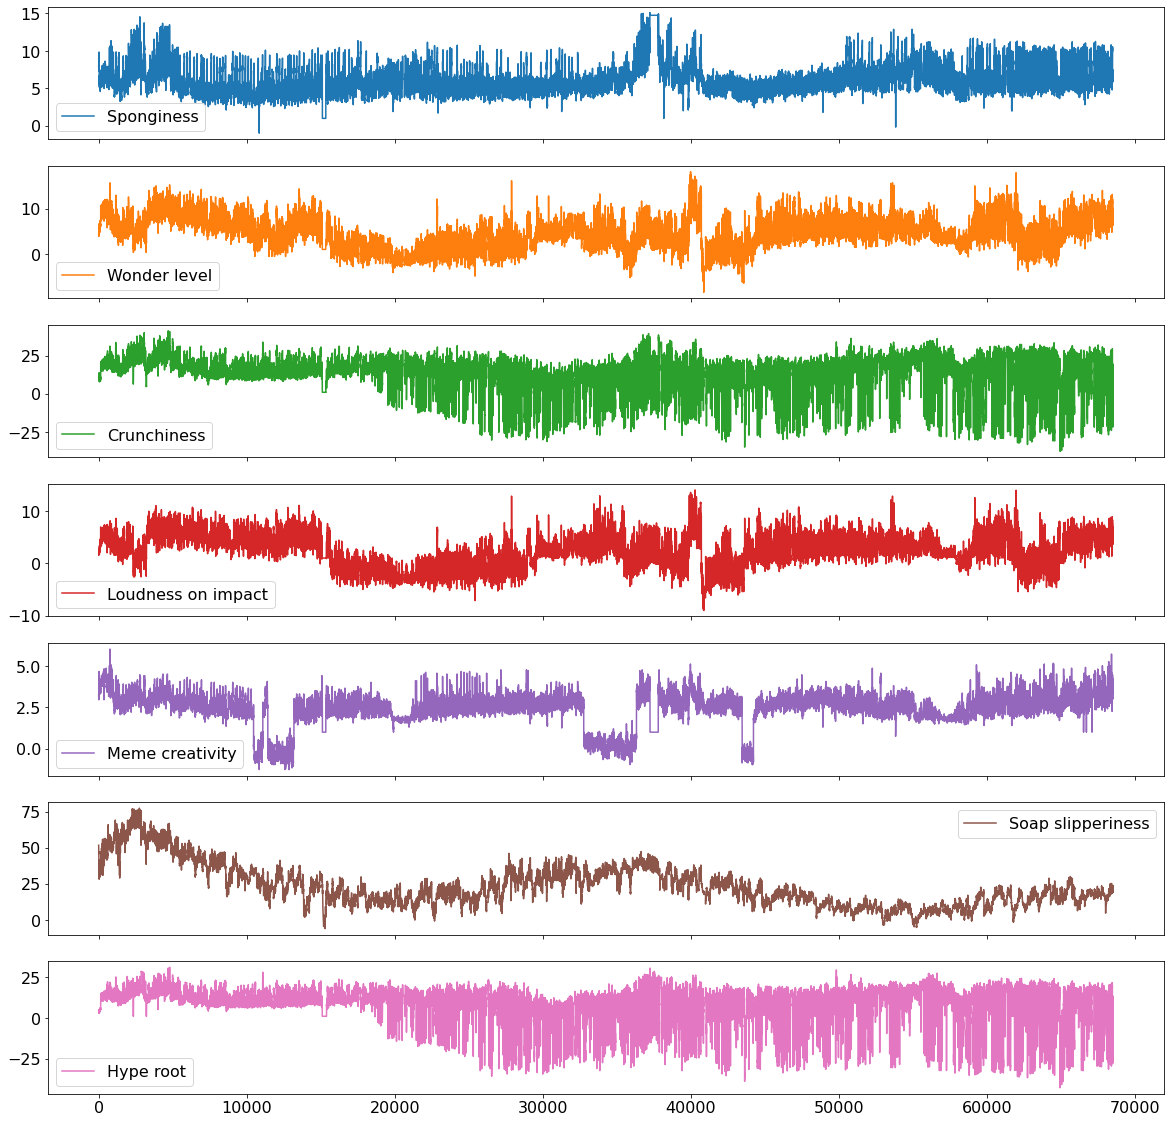

In [4]:
plot_cols = ['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness', 'Hype root']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(20,20))

#### Looking at the plots above, is clear how 'Wonder Level' and 'Loudness on Impact' have the same behaviour. Also 'Sponginess', even if slightly different, has some similiarities with the two time series cited before.
#### Lastly, 'Crunchiness' and 'Hype root' present very similar behaviours during time.
#### This fact may be interpreted as the presence of correlation between the cited time series. However, without any knowledge about the context of each time series ('Crunchiness' doesn't tell anything about what phenomenon the time series describes), is difficult to say.
#### Maybe these informations can be exploited somehow.
#### Let's analyze the time series on a smaller time-frame to see if our intuitions are confirmed.

#### Plotting the time series in a restricted interval

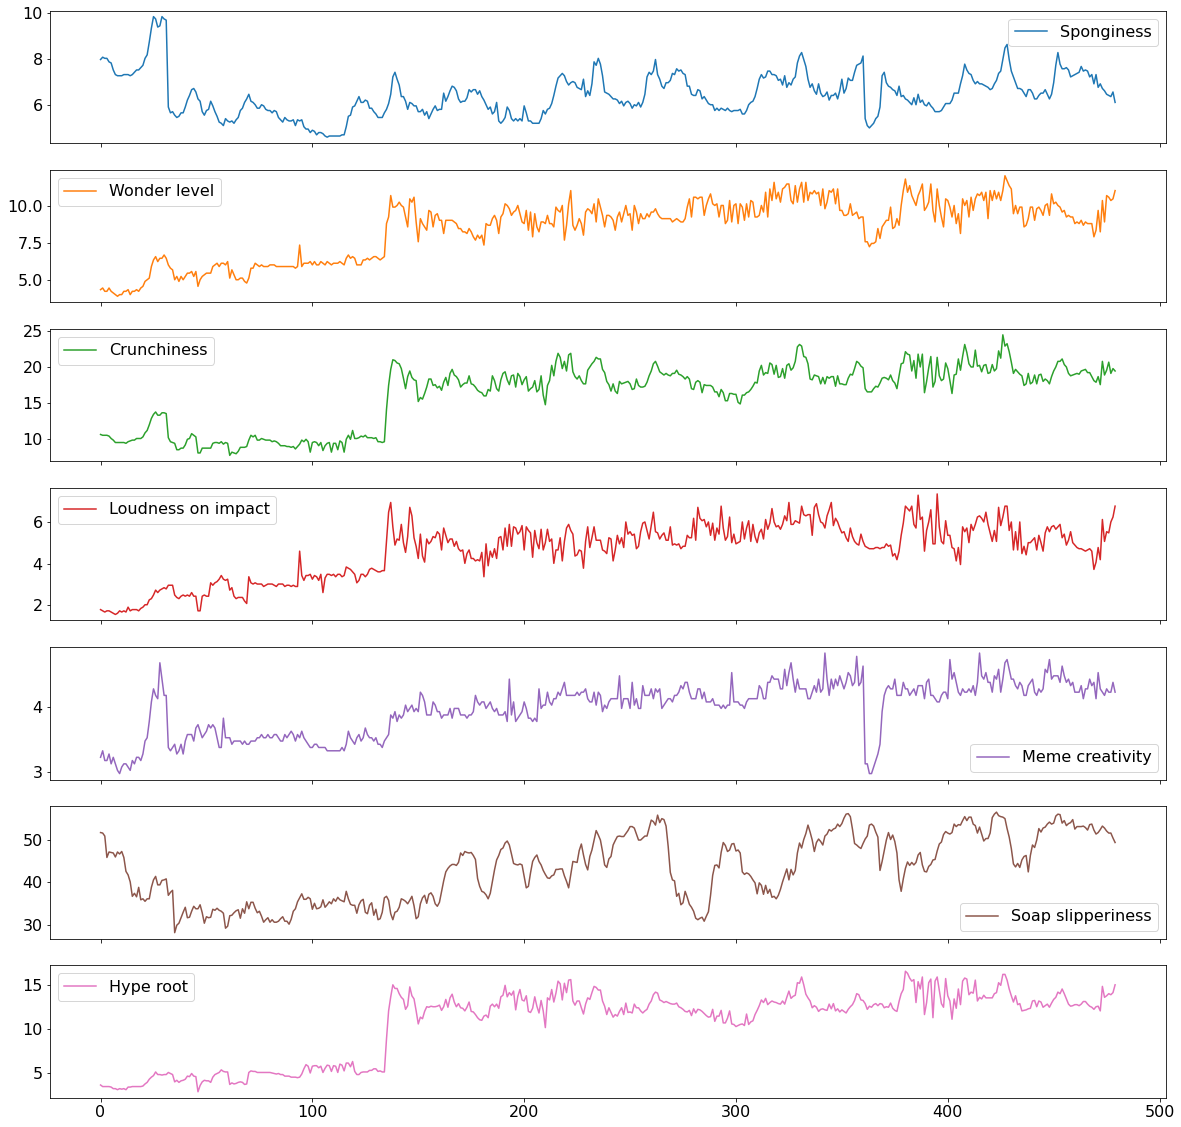

In [5]:
plot_features = df[plot_cols][:480]
_ = plot_features.plot(subplots=True, figsize=(20,20))

 #### The pairs of time series 'Wonder Level' - 'Loudness on Impact' and 'Crunchiness' - 'Hype root' confirm our thoughts about their similar behaviour.
#### While 'Sponginess' present a very different behaviour from the first pair of time series.
#### Another observation needed, is that, is evident, both from the first set of plots, and from this last plots, that the time series under exam don't have any kind of trend or seasonality.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sponginess,68528.0,6.094102,1.941639,-0.972080,4.79144,5.702780,7.067300,15.106680
Wonder level,68528.0,4.695539,3.374224,-8.450380,2.22342,4.668600,7.115440,18.122899
Crunchiness,68528.0,13.337485,11.703203,-37.581721,10.67282,15.676059,20.568080,41.138801
Loudness on impact,68528.0,2.448660,3.001798,-9.028060,0.46880,2.533840,4.656980,14.035980
Meme creativity,68528.0,2.407010,0.994063,-1.275860,2.11220,2.618500,3.021880,6.056360
Soap slipperiness,68528.0,23.237929,14.298260,-6.006860,12.56024,20.151420,31.245199,77.371620
Hype root,68528.0,8.231283,11.285101,-42.769221,6.60416,10.968300,15.334100,31.024420


#### To confirm the absence of trend and seasonality, let's observe if the time series under observation are stationary, this feature is necessary to be able to extract future informations, knowing the past.
#### To do so, first we analyze if the standard deviation and the mean of each of the seven time series, have a constant behaviour. 
#### If so, the time series are stationary.

#### First the meanfig, axs = plt.subplots(nrows=4, ncols=2)

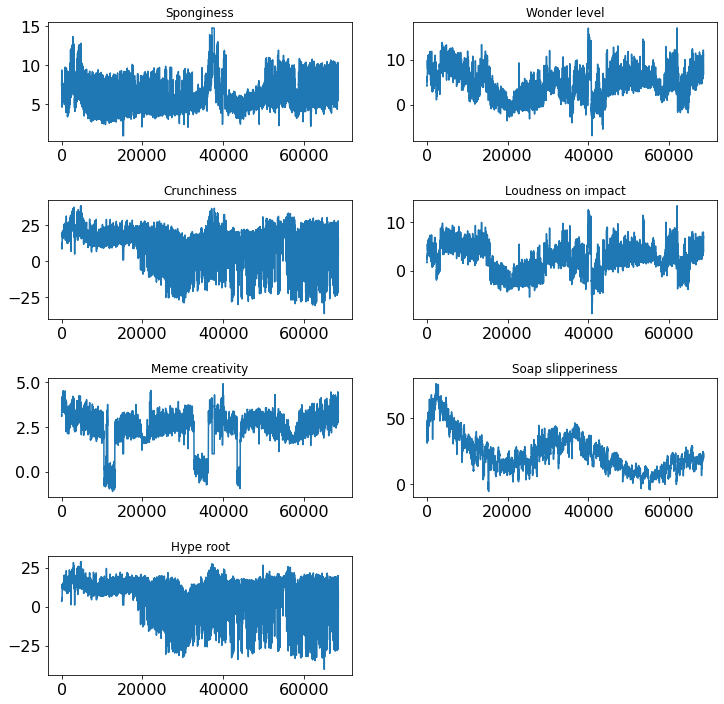

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.delaxes(axs[3,1])
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0, 0].plot(df['Sponginess'].rolling(window=10).mean())
axs[0, 0].set_title('Sponginess', fontsize=12)
axs[0, 1].plot(df['Wonder level'].rolling(window=10).mean())
axs[0, 1].set_title('Wonder level', fontsize=12)
axs[1, 0].plot(df['Crunchiness'].rolling(window=10).mean())
axs[1, 0].set_title('Crunchiness', fontsize=12)
axs[1, 1].plot(df['Loudness on impact'].rolling(window=10).mean())
axs[1, 1].set_title('Loudness on impact', fontsize=12)
axs[2, 0].plot(df['Meme creativity'].rolling(window=10).mean())
axs[2, 0].set_title('Meme creativity', fontsize=12)
axs[2, 1].plot(df['Soap slipperiness'].rolling(window=10).mean())
axs[2, 1].set_title('Soap slipperiness', fontsize=12)
axs[3, 0].plot(df['Hype root'].rolling(window=10).mean())
axs[3, 0].set_title('Hype root', fontsize=12)

fig.subplots_adjust(hspace=0.5)

#### Then the std

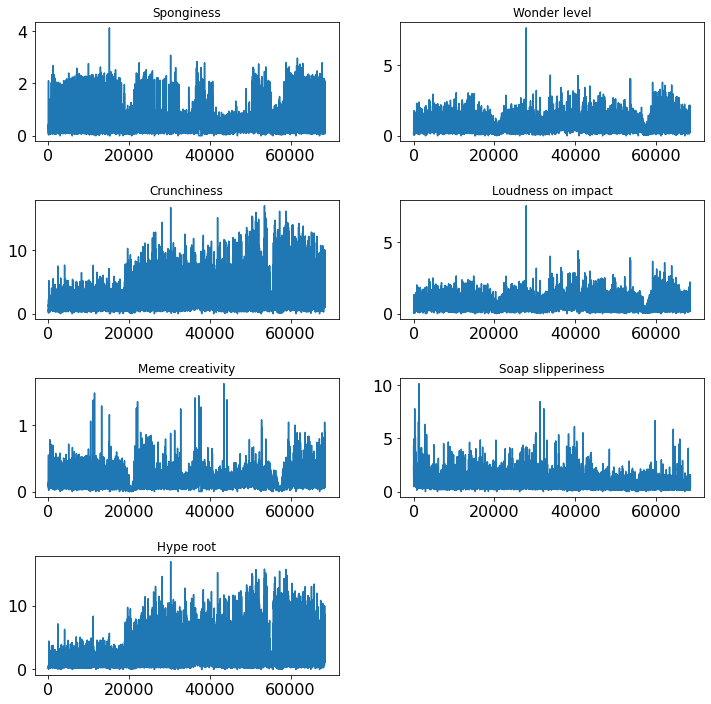

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.delaxes(axs[3,1])
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0, 0].plot(df['Sponginess'].rolling(window=10).std())
axs[0, 0].set_title('Sponginess', fontsize=12)
axs[0, 1].plot(df['Wonder level'].rolling(window=10).std())
axs[0, 1].set_title('Wonder level', fontsize=12)
axs[1, 0].plot(df['Crunchiness'].rolling(window=10).std())
axs[1, 0].set_title('Crunchiness', fontsize=12)
axs[1, 1].plot(df['Loudness on impact'].rolling(window=10).std())
axs[1, 1].set_title('Loudness on impact', fontsize=12)
axs[2, 0].plot(df['Meme creativity'].rolling(window=10).std())
axs[2, 0].set_title('Meme creativity', fontsize=12)
axs[2, 1].plot(df['Soap slipperiness'].rolling(window=10).std())
axs[2, 1].set_title('Soap slipperiness', fontsize=12)
axs[3, 0].plot(df['Hype root'].rolling(window=10).std())
axs[3, 0].set_title('Hype root', fontsize=12)

fig.subplots_adjust(hspace=0.5)

#### The plots of both the mean and the std seems to have pretty constant value during time. 
#### However, it is advisable to have more confidence, to compute the AD Fuller test. 

In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in df.columns.values:
    print("p-value of {0} is: {1}".format(col, adfuller(df[col])[1]))

#### All the time series reject the null hypothesis, so the time series are not random walk, and we can assume stationarity

## Model Building

In [9]:
scaler = MinMaxScaler()
ndf = pd.DataFrame(scaler.fit_transform(df),columns=df.columns) # normalization

test_size = 6800
X_train_raw = ndf.iloc[:-test_size]
X_test_raw = ndf.iloc[-test_size:]
target_labels = ndf.columns

In [10]:
train_mean = X_train_raw.mean()
train_std = X_train_raw.std()

train_df = (X_train_raw - train_mean) / train_std
test_df = (X_test_raw - train_mean) / train_std

In [11]:
def create_folders_and_callbacks(patience, index_name):
    # List of callbacks
    callbacks = []
    
    # Create data_loader folder if it does not exist
    exps_dir = os.path.join('data_loaded')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, "model_" + str(index_name) + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

  # Model checkpoint: allows to automatically save the model during training

    ckpt_dir = os.path.join(exp_dir, 'ckpts')  # create a subfolder in the folder which will contain the model checkpoints
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = \
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(ckpt_dir, 'cp'),
            save_weights_only=False,
            save_best_only=False)  # where i want to save the checkpoints

    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------

    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tb_dir,
        profile_batch=0,
        histogram_freq=1)  # allows to save the histogram of weights over the epochs (the value stands for the epoch frequency)
    
    callbacks.append(tb_callback)
    
  # Reduce LR on plateau
  # --------------
    lrp = tfk.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        patience=patience, 
        factor=0.5, 
        min_lr=0.0003)

  # Early Stopping
  # --------------

    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=0.0003,
        restore_best_weights=True)
    
    callbacks.append(es_callback)
    
    return callbacks

In [12]:
def save_model(model, cfg, index_name):
    model.save("seq2seq" + str(index_name))
    shutil.make_archive('seq2seq' + str(index_name), 'zip', './seq2seq' + str(index_name))
    shutil.make_archive('tbseq2seq' + str(index_name), 'zip', './data_loaded')
    
    # to see the hyperparameter chosen
    with open('./configs.txt', 'a') as configs:
        configs.write(str(cfg))

### Seq2Seq

In [13]:
def build_model(input_shape, output_shape, filt1, filt2, filt3, unit1, unit2, unit3, kernel, learning_rate):
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # defining the encoder
    encoder_last_h1, encoder_last_h2, encoder_last_c = tfkl.LSTM(
        unit1, activation='elu', dropout=0.2, 
        return_sequences=False, return_state=True)(input_layer)
    
    encoder_last_h1 = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)
    
    # defining the decoder
    decoder = tfkl.RepeatVector(output_shape[-2])(encoder_last_h1)
    decoder = tfkl.LSTM(unit1, activation='elu', dropout=0.2, 
                   return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
    
    output_layer = tfkl.TimeDistributed(tfkl.Dense(output_shape[-1]))(decoder)
    
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=learning_rate, clipnorm=1), metrics=['mae'])

    # Return the model
    return model


In [22]:
def build_sequences(df, target_labels, window, stride, telescope=50):
    
    #the telescope tells us how many parameters i want to predict in the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    #target_labels allows to choose how many sensors we are going to predict in the future
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [23]:
# we could apply grid search
def param_def():
    
            # window, stride, filt1, filt2, filt3, unit1, unit2, unit3, kernel, epochs, batch_size, patience, learning_rate, index_name
    cfg_1 = [200,     20,     16,    32,    32,    256,   512,   1024,  3,      50,     32,         10,       1e-03,         1]
    
    configs = list()
    
    configs.append(cfg_1)
    return configs

In [24]:
# fit a model
def model_fit(window, stride, filt1, filt2, filt3, unit1, unit2, unit3, kernel, epochs, batch_size, patience, 
              learning_rate, index_name, train, target_labels, telescope=50):
    
    x_train, y_train = build_sequences(train, target_labels, window, stride, telescope=50)
    
    input_shape = x_train.shape[1:]
    output_shape = y_train.shape[1:]
    
    # define model
    model = build_model(input_shape, output_shape, filt1, filt2, filt3, unit1, unit2, unit3, kernel, learning_rate)
    model.summary()
    
    # define callbacks
    callbacks = create_folders_and_callbacks(patience, index_name)
    
    # Train the model
    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.2,
        callbacks = callbacks
    ).history
    
    return model, history

In [25]:
def fit_predict(train, test, cfg, target_labels):
    predictions = list()
                                
    # unpack config
    window, stride, filt1, filt2, filt3, unit1, unit2, unit3, kernel, epochs, batch_size, patience, learning_rate, index_name = cfg
    
    # fit model
    model, history = model_fit(window, stride, filt1, filt2, filt3, unit1, unit2, unit3, kernel, epochs, batch_size, patience, 
                      learning_rate, index_name, train, target_labels, telescope=50)

    save_model(model, cfg, index_name)

    x_test, y_test = build_sequences(test, target_labels, window, stride, telescope=50)
    
    predictions = model.predict(x_test)
    
    return history, x_test, y_test, predictions

In [26]:
# grid search configs
def grid_search(train, test, cfg_list, target_labels):
    
    models_list = []
    
    for cfg in cfg_list:
        history, x_test, y_test, predictions = fit_predict(train, test, cfg, target_labels)
        model = {'history': history, 'xtest' : x_test, 'ytest': y_test, 'predictions' : predictions}
        models_list.append(model)
        
    return models_list

In [27]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope=50, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6 * 7))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='black', ls='--', lw=2, label='Real')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='blue', lw=2, label='Pred')
        axs[i].set_title(col)
        axs[i].set_xlim(len(X[0,:,i]) - telescope * 5, len(X[0,:,i]) + telescope)
        axs[i].legend(loc='lower left')
    plt.show()

In [28]:
# PLOT OF THE HISTORY

def plot_history(history):

    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error (Loss)')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [29]:
configs = param_def()

file = open("configs.txt", "w") 
file.close()

models = grid_search(X_train_raw, X_test_raw, configs, target_labels)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 200, 7)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 270336      Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256)          1024        lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 50, 256)      0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

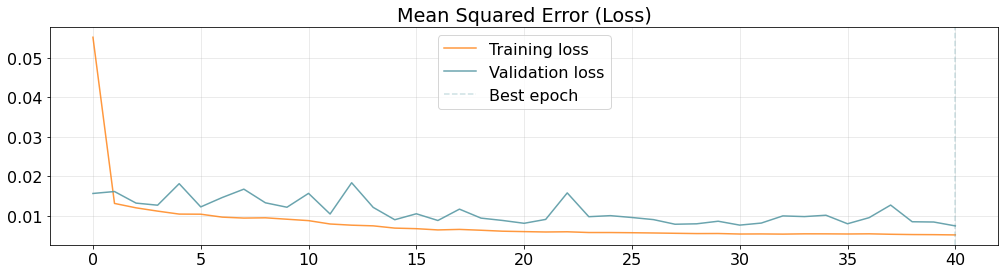

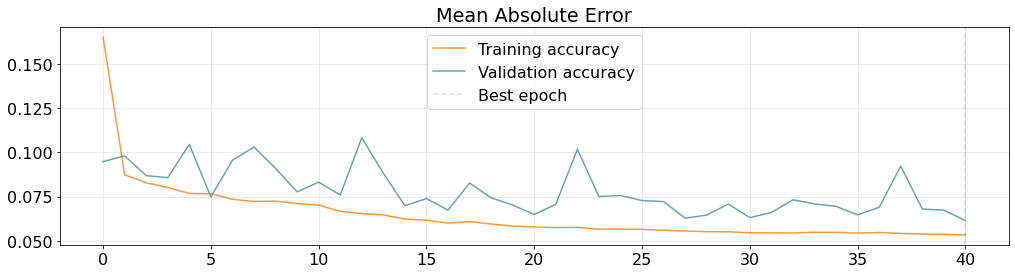

KeyError: 'lr'

<Figure size 1296x216 with 0 Axes>

In [30]:
history = models[0]['history']
plot_history(history)

print(metrics)

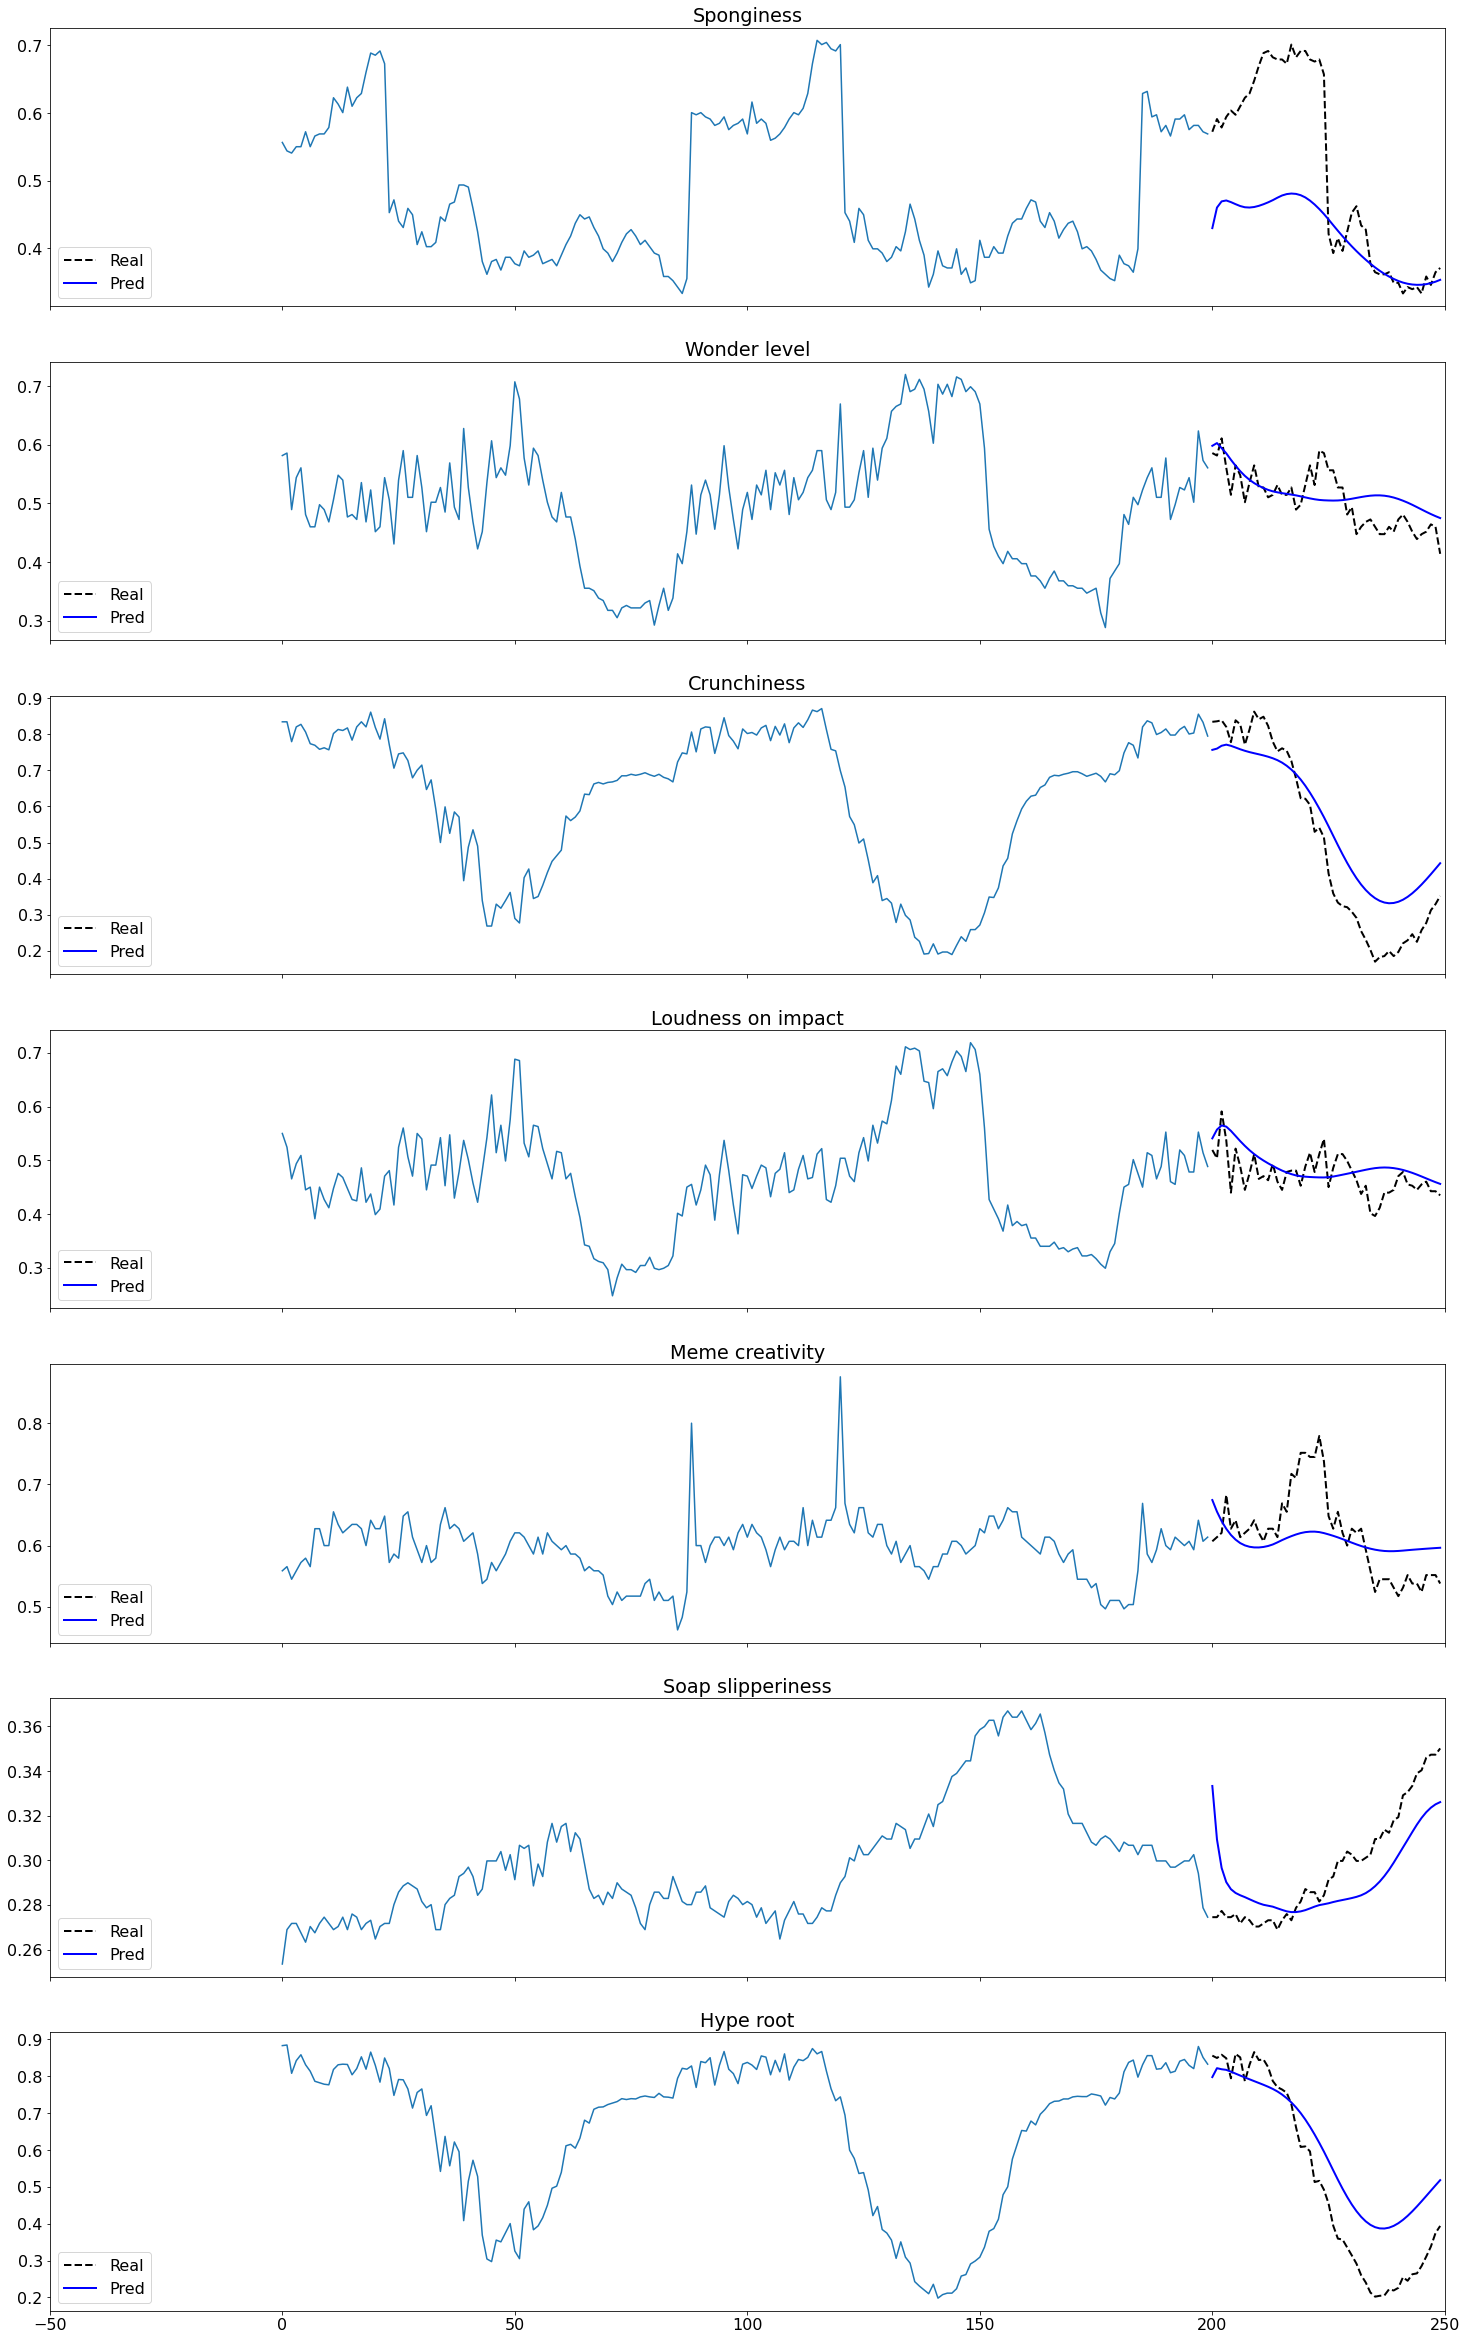

In [31]:
x_test = models[0]['xtest']
y_test = models[0]['ytest']
predictions = models[0]['predictions']
inspect_multivariate_prediction(x_test, y_test, predictions, target_labels, telescope=50)

In [32]:
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print(mean_squared_error)
print(mean_absolute_error)

tf.Tensor(0.008401693, shape=(), dtype=float32)
tf.Tensor(0.06552964, shape=(), dtype=float32)
